In [1]:
import numpy as np
import pandas as pd
import torch
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch import nn, optim, Tensor
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

In [4]:
data = pd.read_pickle('/share/chenqiuyi/value_match_data.pkl') # 原始数据
target = data.iloc[:, 563:].columns.tolist() # 目标列

df = pd.melt(data, id_vars=['id'], value_vars=target, var_name='targetId', value_name='buy') # 将多个目标列转为两列：目标列id，值
df['targetId'] = df['targetId'].str.replace('value', '').astype(int)
print(df.head())
print(len(df['id'].unique())) # ID数
print(len(df['targetId'].unique())) # 目标列数
print(df.describe())

lbl_user = LabelEncoder() # ID编码
lbl_target = LabelEncoder() # 目标列编码
df.id = lbl_user.fit_transform(df.id.values)
df.targetId = lbl_target.fit_transform(df.targetId.values)

                                     id  targetId  buy
0  ab9e82fc-9d67-11ee-be9c-7ec33eed946d         1    0
1  ab9e891e-9d67-11ee-be9c-7ec33eed946d         1    0
2  ab9e89be-9d67-11ee-be9c-7ec33eed946d         1    0
3  ab9e8a2c-9d67-11ee-be9c-7ec33eed946d         1    0
4  ab9e8a90-9d67-11ee-be9c-7ec33eed946d         1    0
1145324
30
           targetId           buy
count  3.435972e+07  3.435972e+07
mean   2.036667e+01  6.252586e-02
std    1.410315e+01  2.421082e-01
min    1.000000e+00  0.000000e+00
25%    8.000000e+00  0.000000e+00
50%    1.550000e+01  0.000000e+00
75%    3.200000e+01  0.000000e+00
max    4.500000e+01  1.000000e+00


In [5]:
print(df.id.max()) # 编码后的ID最大值
print(df.targetId.max()) # 编码后的目标列最大值

1145323
29


In [6]:
df.buy.value_counts() # 统计产品购买情况，1为购买，0为未购买

0    32211349
1     2148371
Name: buy, dtype: int64

In [7]:
purchase_counts = df.groupby('id')['buy'].sum() # 统计每个ID购买的产品数量
print(purchase_counts.value_counts())
print(purchase_counts.mean()) # 平均购买数量，可观察到普遍购买数量较少
print(purchase_counts.min()) # 最少购买数量，可观察到结果为0，说明有些ID没有购买任何产品
print(purchase_counts.max()) # 最多购买数量，可观察到结果为22，说明有些ID购买了很多产品
purchase_counts

1     310437
0     275789
2     229938
3     153282
4      82089
5      41628
6      22823
7      12452
8       6988
9       4165
10      2415
11      1550
12       834
13       455
14       245
15       140
16        50
17        28
18        13
21         1
19         1
22         1
Name: buy, dtype: int64
1.875775763015531
0
22


id
0          0
1          5
2          4
3          0
4          0
          ..
1145319    3
1145320    2
1145321    0
1145322    0
1145323    2
Name: buy, Length: 1145324, dtype: int64

In [8]:
def load_edge(df, src_index_col, dst_index_col, link_index_col, rating_threshold=1):
    ''' 加载边数据

    :param df: 数据集
    :param src_index_col: 源节点列名
    :param dst_index_col: 目标节点列名
    :param link_index_col: 边列名
    :param rating_threshold: 评分阈值
    :return: 边数据

    '''
    edge_index = None
    src = [user_id for user_id in df[src_index_col]]
    dst = [target_id for target_id in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold # 得到评分大于等于阈值的边
    # print(edge_attr)
    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i]) # 源节点
            edge_index[1].append(dst[i]) # 目标节点
    return edge_index

In [9]:
edge_index = load_edge(df, src_index_col='id', dst_index_col='targetId', link_index_col='buy')
print(f"{len(edge_index)} x {len(edge_index[0])}") # 边数据大小
edge_index = torch.LongTensor(edge_index)
print(edge_index)
print(edge_index.size())

2 x 2148371
tensor([[     67,     200,     534,  ..., 1144929, 1145185, 1145300],
        [      0,       0,       0,  ...,      29,      29,      29]])
torch.Size([2, 2148371])


In [10]:
# 保存数据
import pickle
with open('edge_index.pkl', 'wb') as file:
    pickle.dump(edge_index, file)
with open('data.pkl', 'wb') as file:
    pickle.dump(df, file)
with open('lbl_user.pkl', 'wb') as file:
    pickle.dump(lbl_user, file)
with open('lbl_target.pkl', 'wb') as file:
    pickle.dump(lbl_target, file)

In [2]:
df = pd.read_pickle('data.pkl') # 已经处理好的数据
edge_index = pd.read_pickle('edge_index.pkl') # 边数据
lbl_user = pd.read_pickle('lbl_user.pkl') # ID label encoder
lbl_target = pd.read_pickle('lbl_target.pkl') # 目标列 label encoder

In [3]:
num_users = len(df['id'].unique()) # ID数量
num_targets = len(df['targetId'].unique()) # 目标列数量

In [4]:
num_interactions = edge_index.shape[1] # 交互数量
all_indices = [i for i in range(num_interactions)]

# 划分训练集、验证集和测试集
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42)
train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [5]:
# 转为稀疏张量
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1]+num_users, sparse_sizes=(
    num_users + num_targets, num_users + num_targets))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1]+num_users, sparse_sizes=(
    num_users + num_targets, num_users + num_targets))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1]+num_users, sparse_sizes=(
    num_users + num_targets, num_users + num_targets))

In [6]:
print(train_edge_index.size())
print(val_edge_index.size())
print(test_edge_index.size())

torch.Size([2, 1718696])
torch.Size([2, 214837])
torch.Size([2, 214838])


In [7]:
print(f"num_users {num_users}, num_targets {num_targets}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print(f"total number of unique nodes {num_users + num_targets}")
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

num_users 1145324, num_targets 30, num_interactions 2148371
train_edge_index tensor([[ 42195, 470992, 281891,  ..., 335371, 431212, 572095],
        [    28,      0,      3,  ...,      4,      1,     17]])
total number of unique nodes 1145354
torch.Size([796746])
torch.Size([30])


In [8]:
print(train_sparse_edge_index)
print(val_sparse_edge_index)
print(test_sparse_edge_index)

SparseTensor(row=tensor([      1,       1,       1,  ..., 1145320, 1145320, 1145323]),
             col=tensor([1145326, 1145327, 1145336,  ..., 1145326, 1145351, 1145330]),
             size=(1145354, 1145354), nnz=1718696, density=0.00%)
SparseTensor(row=tensor([      2,      21,      34,  ..., 1145313, 1145318, 1145323]),
             col=tensor([1145336, 1145335, 1145335,  ..., 1145341, 1145326, 1145328]),
             size=(1145354, 1145354), nnz=214837, density=0.00%)
SparseTensor(row=tensor([      2,      35,      56,  ..., 1145308, 1145308, 1145314]),
             col=tensor([1145335, 1145340, 1145325,  ..., 1145327, 1145352, 1145341]),
             size=(1145354, 1145354), nnz=214838, density=0.00%)


In [9]:
# 创建一个字典，其中键是源节点，值是与源节点连接的节点集
# 例如，如果源节点1连接到节点2和3，那么字典将如下所示：{1: {2, 3}}
# 这将有助于快速查找源节点的正样本
source_nodes = edge_index[0]
positive_nodes = edge_index[1]
positive_dict = {source: set() for source in source_nodes.tolist()}
for source, node in zip(source_nodes.tolist(), positive_nodes.tolist()):
    positive_dict[source].add(node)

In [10]:
class LightGCN(MessagePassing):
    ''' LightGCN模型
    
    定义了LightGCN模型，该模型由K层GCN组成，每一层的输出是前一层的输出和原始嵌入的均值。

    属性：
    - num_users: 用户数量
    - num_items: 产品数量
    - embedding_dim: 嵌入维度
    - K: GCN层数
    - add_self_loops: 是否添加自环

    '''
    def __init__(self, num_users, num_items, embedding_dim=128, K=3, add_self_loops=False):
        ''' 初始化LightGCN模型
        
        :param num_users: 用户数量
        :param num_items: 产品数量
        :param embedding_dim: 嵌入维度
        :param K: GCN层数
        :param add_self_loops: 是否添加自环
        
        '''        
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        self.bn_list = nn.ModuleList([nn.BatchNorm1d(self.embedding_dim) for _ in range(K)]) # BatchNorm层
        self.dropout_list = nn.ModuleList([nn.Dropout(p=0.2) for _ in range(K)]) # Dropout层
        
        # 初始化嵌入
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        ''' 前向传播
        
        :param edge_index: 边数据
        :return: 用户和产品的嵌入

        '''        
        edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops) # 归一化邻接矩阵
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # e^0
        embs = [emb_0]
        emb_k = emb_0

        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k) # e^k = f(e^{k-1})
            emb_k = self.bn_list[i](emb_k) # BatchNorm
            emb_k = self.dropout_list[i](emb_k) # Dropout
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1) # 将所有层的嵌入堆叠
        emb_final = torch.mean(embs, dim=1) # 求均值
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) # 分割用户和产品的嵌入
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        ''' 消息传递
        
        :param x_j: 目标节点的嵌入
        :return: 目标节点的嵌入
        
        '''
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        ''' 消息传递和聚合
        
        :param adj_t: 邻接矩阵
        :param x: 嵌入
        :return: 聚合后的嵌入
        
        '''
        return matmul(adj_t, x)

In [11]:
class NGCF(MessagePassing):
    ''' NGCF模型

    定义了NGCF模型，该模型由K层GCN组成，每一层的输出是前一层的输出和原始嵌入的线性组合。

    属性：
    - num_users: 用户数量
    - num_items: 产品数量
    - embedding_dim: 嵌入维度
    - K: GCN层数
    - add_self_loops: 是否添加自环

    '''
    def __init__(self, num_users, num_items, embedding_dim=128, K=5, add_self_loops=False):
        ''' 初始化NGCF模型
        
        :param num_users: 用户数量
        :param num_items: 产品数量
        :param embedding_dim: 嵌入维度
        :param K: GCN层数
        :param add_self_loops: 是否添加自环
        
        '''        
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        self.W1_list = nn.ModuleList([nn.Linear(self.embedding_dim,self.embedding_dim,bias=False) for _ in range(K)]) # 线性层
        self.W2_list = nn.ModuleList([nn.Linear(self.embedding_dim,self.embedding_dim,bias=False) for _ in range(K)]) # 线性层
        # self.bn_list = nn.ModuleList([nn.BatchNorm1d(self.embedding_dim) for _ in range(K)]) # BatchNorm层
        self.dropout_list = nn.ModuleList([nn.Dropout(p=0.2) for _ in range(K)]) # Dropout层
    
        # 初始化参数
        self.init_weights()

    def init_weights(self):
        ''' 初始化参数

        利用Xavier初始化参数，对于每个参数，从均匀分布U(-a, a)中采样，其中a = gain * sqrt(2 / (fan_in + fan_out))。
        
        '''
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def forward(self, edge_index: SparseTensor):
        ''' 前向传播
        
        :param edge_index: 边数据，邻接矩阵
        :return: 用户和产品的嵌入，e_u^K, e_u^0, e_i^K, e_i^0
        
        '''
        edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops) # 归一化邻接矩阵
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # e^0
        embs = [emb_0]
        emb_k = emb_0

        # 多尺度扩散，multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k, K=i) + self.W1_list[i](emb_k) # e^k = f(e^{k-1}) + W1 * e^{k-1}
            # emb_k = self.bn_list[i](emb_k) # BatchNorm
            emb_k = F.leaky_relu(emb_k) # 激活函数，LeakyReLU
            emb_k = self.dropout_list[i](emb_k) # Dropout
            embs.append(emb_k)

        emb_final = torch.cat(embs, dim=1) # e^k, e^{k-1}, ..., e^0

        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) # 分割成e_u^K和e_i^K
        
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_i: Tensor, x_j: Tensor, K: int ) -> Tensor:
        ''' 消息传递
        
        :param x_i: 源节点的嵌入
        :param x_j: 目标节点的嵌入
        :param K: GCN层数
        :return: 目标节点的嵌入
        
        '''
        return self.W1_list[K](x_i) + self.W2_list[K](x_i * x_j)

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        ''' 消息传递和聚合
        
        :param adj_t: 邻接矩阵
        :param x: 嵌入
        :return: 聚合后的嵌入
        
        '''
        return matmul(adj_t, x)

In [12]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    ''' BPR损失函数
    
    :param users_emb_final: 用户的最终嵌入
    :param users_emb_0: 用户的初始嵌入
    :param pos_items_emb_final: 正样本产品的最终嵌入
    :param pos_items_emb_0: 正样本产品的初始嵌入
    :param neg_items_emb_final: 负样本产品的最终嵌入
    :param neg_items_emb_0: 负样本产品的初始嵌入
    :param lambda_val: 正则化系数
    :return: 损失值
    
    '''
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) + pos_items_emb_0.norm(2).pow(2) + neg_items_emb_0.norm(2).pow(2)) # L2正则化，防止过拟合
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # 正样本的预测分数
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # 负样本的预测分数
    loss = -F.logsigmoid(pos_scores - neg_scores).sum() + reg_loss # BPR损失
    return loss

In [13]:
def get_user_positive_items(edge_index):
    ''' 获取用户的正样本产品

    :param edge_index: 边数据
    :return: 用户的正样本产品，字典形式，键是用户，值是产品列表

    '''
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [14]:
def RecallPrecision_ATk(groundTruth, r, k):
    ''' 计算Recall和Precision
    
    :param groundTruth: 真实值
    :param r: 预测值
    :param k: Top K
    :return: Recall和Precision
    
    '''
    num_correct_pred = torch.sum(r, dim=-1) # 正确预测的数量
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))]) # 用户喜欢的产品数量
    recall = torch.mean(num_correct_pred / user_num_liked) # Recall = TP / (TP + FN)
    precision = torch.mean(num_correct_pred) / k # Precision = TP / (TP + FP)
    return recall.item(), precision.item()

def NDCGatK_r(groundTruth, r, k):
    ''' 计算NDCG
    
    :param groundTruth: 真实值
    :param r: 预测值
    :param k: Top K
    :return: NDCG
    
    '''
    assert len(r) == len(groundTruth) # 预测值和真实值的长度必须相同
    test_matrix = torch.zeros((len(r), k))
    for i, items in enumerate(groundTruth): # 对于每个用户，将真实值转为矩阵，1表示用户喜欢的产品，0表示不喜欢的产品
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1) # 真实值的IDCG
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2))) # 预测值的DCG
    dcg = torch.sum(dcg, axis=1) # DCG
    idcg[idcg == 0.] = 1. # 防止除零
    ndcg = dcg / idcg # NDCG
    ndcg[torch.isnan(ndcg)] = 0. # 防止NaN
    return torch.mean(ndcg).item()

# def AUC(all_item_scores, num_items, test_data):
#     """
#         design for a single user
#     """
#     dataset : BasicDataset
#     r_all = np.zeros((num_items, ))
#     r_all[test_data] = 1
#     r = r_all[all_item_scores >= 0]
#     test_item_scores = all_item_scores[all_item_scores >= 0]
#     return roc_auc_score(r, test_item_scores)

In [15]:
def negative_sampling(positive_dict, batch_pos_edges, num_users, num_items):
    ''' 负采样
    
    :param positive_dict: 正样本字典
    :param batch_pos_edges: 批量正样本
    :param num_users: 用户数量
    :param num_items: 产品数量
    :return: 负样本（源节点，目标节点，负样本节点）
    
    '''
    sources = batch_pos_edges[0] # 源节点
    negative_nodes = torch.randint(0, num_items, (batch_pos_edges.shape[1],)).tolist() # 随机负样本
    for i, source in enumerate(sources.tolist()):
        node = negative_nodes[i]
        while node in positive_dict[source]: # 如果负样本是正样本，则重新采样
            node = torch.randint(0, num_items, (1,)).item()
            negative_nodes[i] = node
    return batch_pos_edges[0], batch_pos_edges[1], torch.tensor(negative_nodes)

In [16]:
def get_metrics(model, edge_index, sparse_edge_index, exclude_edge_index, train_sparse_edge_index, k):
    ''' 获取评估指标
    
    :param model: 模型
    :param edge_index: 边数据
    :param sparse_edge_index: 稀疏边数据
    :param exclude_edge_index: 排除的边数据
    :param train_sparse_edge_index: 训练集稀疏边数据
    :param k: Top K
    :return: Recall, Precision, NDCG
    
    '''
    user_embedding, _, item_embedding, _  = model.forward(sparse_edge_index) # 用户和产品的嵌入
    
    # 转为numpy
    user_embedding = np.array(user_embedding.cpu().detach().numpy())
    item_embedding = np.array(item_embedding.cpu().detach().numpy())
    
    # 评分
    rating = torch.tensor(np.matmul(user_embedding, item_embedding.T))

#     user_embedding = model.users_emb.weight
#     item_embedding = model.items_emb.weight
#     rating = torch.matmul(user_embedding, item_embedding.T)
    
    user_pos_items = get_user_positive_items(exclude_edge_index) # 得到用户的正样本产品
    exclude_users = []
    exclude_items = []
    for user, items in user_pos_items.items():
        exclude_users.extend([user] * len(items)) # 
        exclude_items.extend(items) # 
    rating[exclude_users, exclude_items] = -(1 << 10) # 
    
    _, top_K_items = torch.topk(rating, k=k) # Top K产品
    
    users = edge_index[0].unique()
    test_user_pos_items = get_user_positive_items(edge_index)
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]
    
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))
    
    # rating = rating.cpu().numpy()
    # aucs = [AUC(rating[i], num_targets, test_data) for i, test_data in enumerate(test_user_pos_items_list)]
    # auc = np.mean(aucs)
    
    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [17]:
def plot_curves(train_losses, recalls, precisions, ndcgs, f1s):
    ''' 绘制曲线
    
    :param train_losses: 训练损失
    :param recalls: 召回率
    :param precisions: 精确度
    :param ndcgs: NDCG
    :param f1s: F1分数
    
    '''
    iters1 = [iter for iter in range(len(train_losses))]
    plt.plot(iters1, train_losses, label='train') # 训练损失
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('training loss curves')
    plt.legend()
    plt.show()

    iters = [iter for iter in range(len(recalls))]
    plt.subplot(221)
    plt.plot(iters, recalls) # 召回率
    plt.title("recall")
    plt.subplot(222)
    plt.plot(iters, precisions) # 精确度
    plt.title("precision")
    plt.subplot(223)
    plt.plot(iters, ndcgs) # NDCG
    plt.title("ndcg")
    plt.subplot(224)
    plt.plot(iters, f1s)
    plt.title("f1_score")
    plt.xlabel('iteration') # F1分数
    plt.ylabel('score')
    plt.legend()
    plt.show()

In [18]:
def train(epochs, batch_size, lambda_, check_step, K, device, model, optimizer, scheduler):
    ''' 训练模型
    
    :param epochs: 迭代次数
    :param batch_size: 批量大小
    :param lambda_: 正则化系数
    :param check_step: 检查步数
    :param K: Top K
    :param device: 设备
    :param model: 模型
    :param optimizer: 优化器
    :param scheduler: 学习率调度器
    :return: 训练后的模型
    
    '''
    max_score = 0
    train_losses = []
    recalls = []
    precisions = []
    ndcgs = []
    f1s = []
    for epoch in tqdm(range(1, epochs+1)):
        model.train() # 训练模式
        trn_loader = DataLoader(train_edge_index.T, batch_size, shuffle=True) # 数据加载器
        trn_loss = 0
        
        for batch_pos_edges in trn_loader:
            users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index) # 前向传播
            
            batch_pos_edges = batch_pos_edges.T
            batch_neg_edges = negative_sampling(positive_dict, batch_pos_edges, num_users, num_targets) # 负采样
            user_indices, pos_item_indices, neg_item_indices = batch_neg_edges[0].to(device), batch_neg_edges[1].to(device), batch_neg_edges[2].to(device)

            # 分别得到用户、正样本产品和负样本产品的初始化和最终嵌入      
            users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
            pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
            neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

            loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_) # 计算损失
            
            optimizer.zero_grad() # 梯度清零
            loss.backward() # 反向传播
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # 梯度截断，防止梯度爆炸，选择性使用
            optimizer.step() # 更新参数
            
            trn_loss += loss.item()
            
        trn_loss = trn_loss / len(trn_loader)
        train_losses.append(trn_loss)
        if epoch != 0 and epoch % check_step == 0:
            model.eval() # 评估模式
            recall, precision, ndcg = get_metrics(model, val_edge_index, val_sparse_edge_index, train_edge_index, train_sparse_edge_index, K) # 获取评估指标
            f1_score = (2 * precision * recall) / (precision + recall) # F1 = 2 * (precision * recall) / (precision + recall)

            recalls.append(recall)
            precisions.append(precision)
            ndcgs.append(ndcg)
            f1s.append(f1_score)
            if ndcg > max_score: # 保存最佳模型
                max_score = ndcg
                torch.save(model.state_dict(), 'ngcf.pt')
                # torch.save(model.state_dict(), 'lightgcn.pt')
            model = model.to(device) # 以防'get_metrics'函数中使用了np.matmul而不是torch.matmul
            scheduler.step() # 学习率调度
            print(f'[{epoch:03d}/{epochs}] | loss: {trn_loss:.6f} | recall@{K}: {recall:.6f} | '
                f'precision@{K}: {precision:.6f} | ndcg@{K}: {ndcg:.6f} | f1_score: {f1_score:.6f}')
    plot_curves(train_losses, recalls, precisions, ndcgs, f1s) # 绘制曲线
    return model

In [19]:
def evaluation(model):
    ''' 评估模型
    
    :param model: 模型
    
    '''
    batch_size = 2**8
    lambda_ = 1e-4
    K = 5
    model.eval() # 评估模式
    with torch.no_grad(): # 不计算梯度
        test_loader = DataLoader(test_edge_index.T, batch_size, shuffle=True) # 加载测试数据
        test_loss = 0

        for batch_pos_edges in test_loader:
            users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(test_sparse_edge_index) # 前向传播
            batch_pos_edges = batch_pos_edges.T
            batch_neg_edges = negative_sampling(positive_dict, batch_pos_edges, num_users, num_targets) # 负采样
            user_indices, pos_item_indices, neg_item_indices = batch_neg_edges[0].to(device), batch_neg_edges[1].to(device), batch_neg_edges[2].to(device)
            users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
            pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
            neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
            loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_) # 计算损失
            test_loss += loss.item()

        test_loss = test_loss / len(test_loader)
        test_recall, test_precision, test_ndcg = get_metrics(model, test_edge_index, test_sparse_edge_index, train_edge_index, train_sparse_edge_index, K) # 计算评估指标
        test_f1_score = (2 * test_precision * test_recall) / (test_precision + test_recall)
        print(f'loss: {test_loss:.6f} | recall@{K}: {test_recall:.6f} | '
                        f'precision@{K}: {test_precision:.6f} | ndcg@{K}: {test_ndcg:.6f} | f1_score: {test_f1_score:.6f}')

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 设备
print(f"Using device {device}.")

train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)
val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


 10%|█         | 10/100 [07:30<1:45:32, 70.37s/it]

[010/100] | loss: 12120.803512 | recall@5: 0.810671 | precision@5: 0.181406 | ndcg@5: 0.588328 | f1_score: 0.296470


 20%|██        | 20/100 [14:58<1:33:23, 70.04s/it]

[020/100] | loss: 4597.416942 | recall@5: 0.862644 | precision@5: 0.194637 | ndcg@5: 0.681560 | f1_score: 0.317612


 30%|███       | 30/100 [22:29<1:23:06, 71.23s/it]

[030/100] | loss: 3424.537914 | recall@5: 0.864815 | precision@5: 0.195518 | ndcg@5: 0.701749 | f1_score: 0.318932


 40%|████      | 40/100 [29:58<1:09:53, 69.88s/it]

[040/100] | loss: 2921.825555 | recall@5: 0.873535 | precision@5: 0.197537 | ndcg@5: 0.716369 | f1_score: 0.322211


 50%|█████     | 50/100 [37:24<57:32, 69.06s/it]  

[050/100] | loss: 2635.609520 | recall@5: 0.872826 | precision@5: 0.197516 | ndcg@5: 0.722913 | f1_score: 0.322135


 60%|██████    | 60/100 [44:56<47:10, 70.77s/it]

[060/100] | loss: 2448.979140 | recall@5: 0.883685 | precision@5: 0.199865 | ndcg@5: 0.733502 | f1_score: 0.325998


 70%|███████   | 70/100 [52:25<35:01, 70.07s/it]

[070/100] | loss: 2329.639599 | recall@5: 0.885766 | precision@5: 0.200347 | ndcg@5: 0.736258 | f1_score: 0.326781


 80%|████████  | 80/100 [59:46<22:32, 67.62s/it]

[080/100] | loss: 2241.143740 | recall@5: 0.883861 | precision@5: 0.199987 | ndcg@5: 0.738005 | f1_score: 0.326173


 90%|█████████ | 90/100 [1:07:17<11:39, 69.92s/it]

[090/100] | loss: 2173.313137 | recall@5: 0.889907 | precision@5: 0.201308 | ndcg@5: 0.742519 | f1_score: 0.328342


100%|██████████| 100/100 [1:14:35<00:00, 44.76s/it]

[100/100] | loss: 2123.023129 | recall@5: 0.887839 | precision@5: 0.200853 | ndcg@5: 0.742264 | f1_score: 0.327595


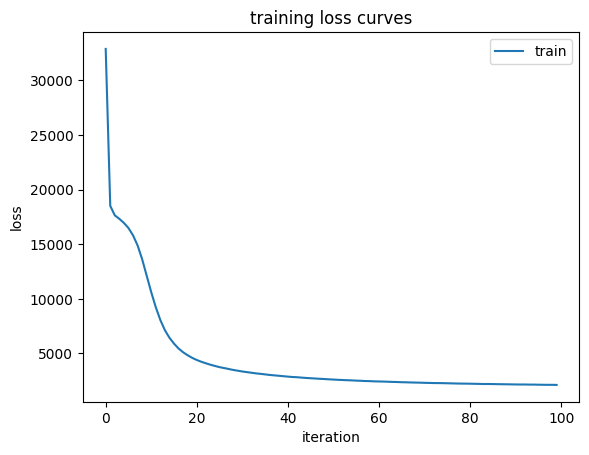

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


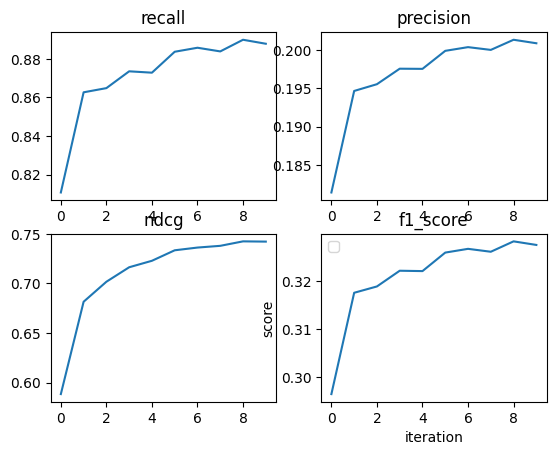

In [22]:
lightgcn = LightGCN(num_users=num_users, num_items=num_targets) # LightGCN模型
lightgcn = lightgcn.to(device)
# optimizer = optim.Adam(lightgcn.parameters(), lr=lr)
optimizer = optim.AdamW(lightgcn.parameters(), lr=0.01, weight_decay=1e-4) # AdamW优化器，加入L2正则化
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # 学习率调度器，指数衰减
lightgcn = train(epochs=100, batch_size=2**16, lambda_=1e-4, check_step=10, K=5, device=device, model=lightgcn, optimizer=optimizer, scheduler=scheduler) # 训练模型

In [ ]:
ngcf = NGCF(num_users=num_users, num_items=num_targets) # NGCF模型
ngcf = ngcf.to(device)
# optimizer = optim.Adam(ngcf.parameters(), lr=lr)
optimizer = optim.AdamW(ngcf.parameters(), lr=0.001, weight_decay=1e-4) # AdamW优化器，加入L2正则化
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # 学习率调度器，指数衰减
ngcf = train(epochs=50, batch_size=2**16, lambda_=1e-4, check_step=10, K=5, device=device, model=ngcf, optimizer=optimizer, scheduler=scheduler) # 训练模型

 20%|██        | 10/50 [10:41<1:05:54, 98.87s/it]

[010/50] | loss: 7873.700905 | recall@5: 0.717718 | precision@5: 0.162082 | ndcg@5: 0.540507 | f1_score: 0.264445


 40%|████      | 20/50 [21:13<48:19, 96.66s/it]  

[020/50] | loss: 2830.441897 | recall@5: 0.747871 | precision@5: 0.169167 | ndcg@5: 0.586221 | f1_score: 0.275922


 60%|██████    | 30/50 [31:54<32:48, 98.42s/it]

[030/50] | loss: 1605.473428 | recall@5: 0.738091 | precision@5: 0.167212 | ndcg@5: 0.590363 | f1_score: 0.272654


 80%|████████  | 40/50 [42:29<16:07, 96.71s/it]

[040/50] | loss: 1070.896437 | recall@5: 0.730901 | precision@5: 0.165737 | ndcg@5: 0.591027 | f1_score: 0.270204


100%|██████████| 50/50 [53:02<00:00, 63.65s/it]

[050/50] | loss: 787.594088 | recall@5: 0.723436 | precision@5: 0.164175 | ndcg@5: 0.586644 | f1_score: 0.267617


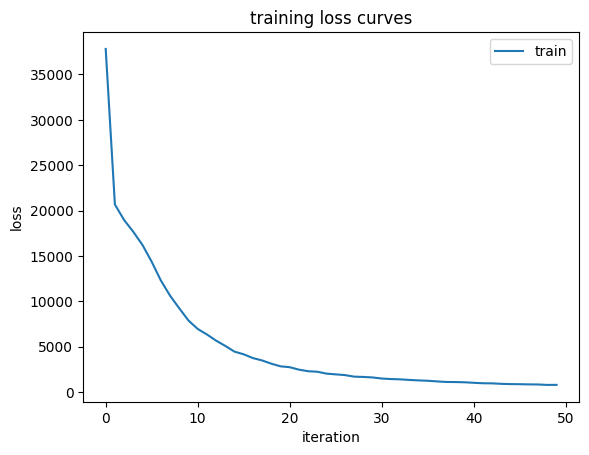

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


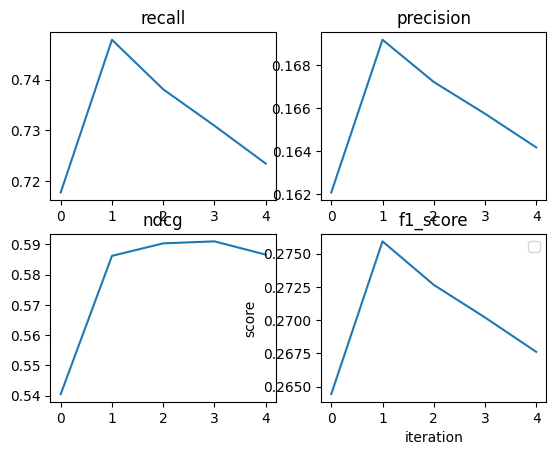

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

In [ ]:
model = NGCF(num_users=num_users, num_items=num_targets)
model.load_state_dict(torch.load('ngcf.pt')) # 加载最佳模型
model = model.to(device)
evaluation(model) # 评估模型

loss: 75.449750 | recall@5: 0.748774 | precision@5: 0.169149 | ndcg@5: 0.587395 | f1_score: 0.275959


In [41]:
model = LightGCN(num_users=num_users, num_items=num_targets)
model.load_state_dict(torch.load('lightgcn.pt')) # 加载最佳模型
model = model.to(device)
evaluation(model) # 评估模型

loss: 45.987277 | recall@5: 0.890655 | precision@5: 0.200998 | ndcg@5: 0.742478 | f1_score: 0.327979


In [42]:
rating = torch.matmul(model.users_emb.weight, model.items_emb.weight.T) # 预测评分
print(rating.size())
rating

torch.Size([1145324, 30])


tensor([[  0.7636,   1.0429,  -2.5606,  ...,  -0.9801,  -2.1676,  -0.0626],
        [ -7.3923, -14.9232,  37.2436,  ..., -16.9615, -17.5303, -16.0048],
        [ -6.0736,  -6.2143,  59.3836,  ...,  -5.5511,   1.4359,  -2.3346],
        ...,
        [ -1.0744,   0.4127,   0.8346,  ...,   0.1279,  -0.2014,  -1.9680],
        [  0.9262,   0.1775,   0.5527,  ...,   0.8737,   1.5381,   0.5267],
        [ -9.4030,  -9.4505,  -4.2228,  ...,  -6.6640,   1.0476,   3.5578]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [55]:
def make_predictions(user_id, K=5):
    ''' 生成推荐
    
    :param user_id: 用户ID
    :param K: Top K
    :return: 推荐产品列表
    
    '''
    user = lbl_user.transform([user_id])[0] # 得到用户ID编码后的值
    e_u = np.array(model.users_emb.weight.cpu().detach().numpy())[user] # 用户的嵌入
    i_u = np.array(model.items_emb.weight.cpu().detach().numpy()) # 产品的嵌入
    # scores = model.items_emb.weight @ e_u
    scores = torch.tensor(i_u @ e_u) # 评分

    exclude_items = user_pos_items.get(user, []) # 排除用户已经购买的产品
    scores[exclude_items] = -(1 << 10) # 排除用户已经购买的产品
    values, indices = torch.topk(scores, k=K) # Top K产品
    rec_item_list = lbl_target.inverse_transform(indices) # 推荐产品
    return rec_item_list

In [56]:
user_id = 'ab9e82fc-9d67-11ee-be9c-7ec33eed946d'
rec_item_list = make_predictions(user_id)
rec_item_list

array([ 2,  4, 30,  1, 39])